In [ ]:
import pandas as pd
import seaborn as sns

clean_df = pd.read_csv("cleaned_data.csv", sep=";")

sns.set_palette("rocket")

In [ ]:
with pd.option_context("display.float_format", "{:.1f}".format):
    print(
        clean_df["price_pln"].describe(
            percentiles=[0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95]
        )
    )

price_ranges = [
    0,
    3_000,
    5_000,
    10_000,
    20_000,
    50_000,
    80_000,
    100_000,
    150_000,
    200_000,
    300_000,
    400_000,
    500_000,
    600_000,
    700_000,
    800_000,
    4_000_000,
]
df = clean_df.drop(
    [
        "url",
        "color",
        "posted_date",
        "price_net_info",
        "location",
        "price",
        "country_of_origin",
    ],
    axis=1,
    errors="ignore",
)

df["capacity"] = (
    df["capacity"]
    .str.replace(" cm3", "", regex=False)
    .str.replace(" ", "")
    .astype(float)
)

df["power"] = (
    df["power"].str.replace(" ", "").str.replace("KM", "", regex=False).astype(float)
)

df["mileage"] = (
    df["mileage"].str.replace(" km", "", regex=False).str.replace(" ", "").astype(float)
)

df["price_pln"] = (
    df["price_pln"].str.replace(" ", "").str.replace(",", ".").astype(float)
)

df = df.dropna(
    subset=[
        "model",
        "condition",
        "fuel",
        "brand",
        "body_type",
        "accident_free",
        "year",
        "capacity",
        "power",
        "mileage",
        "seats",
        "description",
    ]
)

count      13662
unique      4224
top       59 900
freq         120
Name: price_pln, dtype: object


In [ ]:
df["price_pln"].describe()

count    9.903000e+03
mean     1.284310e+05
std      1.146083e+05
min      2.700000e+03
25%      5.490000e+04
50%      1.099000e+05
75%      1.666650e+05
max      2.560000e+06
Name: price_pln, dtype: float64

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9903 entries, 0 to 13661
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   brand          9903 non-null   object 
 1   model          9903 non-null   object 
 2   seats          9903 non-null   float64
 3   year           9903 non-null   float64
 4   fuel           9903 non-null   object 
 5   capacity       9903 non-null   float64
 6   power          9903 non-null   float64
 7   body_type      9903 non-null   object 
 8   gearbox        9815 non-null   object 
 9   mileage        9903 non-null   float64
 10  condition      9903 non-null   object 
 11  accident_free  9903 non-null   object 
 12  title          9903 non-null   object 
 13  price_pln      9903 non-null   float64
 14  equipment      9903 non-null   object 
 15  description    9903 non-null   object 
dtypes: float64(6), object(10)
memory usage: 1.3+ MB


In [332]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder
from stop_words import get_stop_words


pl_stopwords = get_stop_words("pl")


X = df.drop(["price_pln"], axis=1, errors="ignore")
# X["equipment"] = X["equipment"].sort_values()
y = pd.cut(df["price_pln"], bins=price_ranges, labels=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_feats = ["model", "condition", "fuel", "brand", "body_type", "accident_free"]
# cat_feats = ["model", "brand", "accident_free"]
num_feats = ["year", "capacity", "power", "mileage", "seats"]
# num_feats = ["year", "capacity", "power", "mileage"]

,count,price_range
price_pln,,
0,1,0
1,7,3000
2,76,5000
3,281,10000
4,1839,20000
5,1723,50000
6,795,80000
7,2047,100000
8,1628,150000


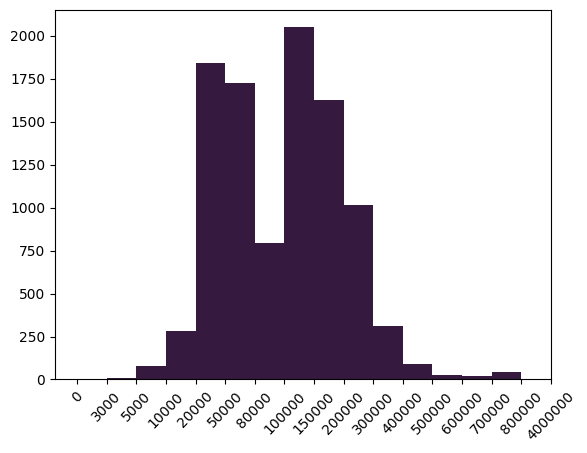

In [333]:
plt.hist(y, bins=max(y))
plt.xticks(list(range(len(price_ranges))), price_ranges, rotation=46)


classes_stat = pd.DataFrame(y.value_counts())
classes_stat["price_range"] = classes_stat.index.map(lambda x: price_ranges[x])
classes_stat.sort_index()

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

text_col = "description"

rfecv_preprocess = ColumnTransformer(
    [
        ("num", "passthrough", num_feats),
        ("cat", TargetEncoder(), cat_feats),
    ],
    remainder="drop",
)

rfecv_model = Pipeline(
    [
        ("prep", rfecv_preprocess),
        (
            "rfecv",
            RFECV(
                estimator=RandomForestClassifier(n_estimators=250, n_jobs=-1),
                cv=3,
                step=1,
                # verbose=1,
                scoring="accuracy",
                n_jobs=-1,
            ),
        ),
    ]
)


rfecv_model.fit(X_train, y_train)

mask = rfecv_model.named_steps["rfecv"].support_

selected_num_cols = [
    col for col, keep in zip(num_feats + cat_feats, mask) if keep and col in num_feats
]
selected_cat_cols = [
    col for col, keep in zip(num_feats + cat_feats, mask) if keep and col in cat_feats
]

print("Kept numeric:", selected_num_cols)
print("Kept categorical:", selected_cat_cols)

/Users/tomekogiolda/Projects/agh/.conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/tomekogiolda/Projects/agh/.conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Fitting estimator with 52 features.
Fitting estimator with 52 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 51 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 43 fe

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


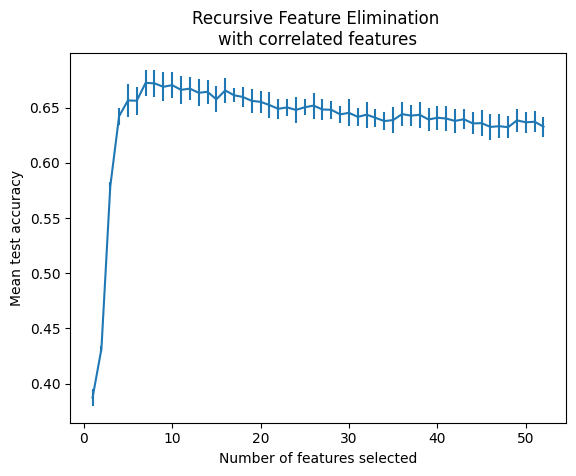

In [ ]:
data = {
    key: value
    for key, value in rfecv_model.named_steps['rfecv'].cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

## RFECV without description field

accuracy: 0.6824835941443715

report:
               precision    recall  f1-score   support

           2       0.60      0.50      0.55         6
           3       0.69      0.40      0.51        62
           4       0.72      0.75      0.73       361
           5       0.63      0.74      0.68       346
           6       0.60      0.44      0.51       171
           7       0.72      0.75      0.73       410
           8       0.70      0.70      0.70       335
           9       0.68      0.72      0.70       193
          10       0.63      0.49      0.55        59
          11       0.88      0.61      0.72        23
          12       0.17      0.50      0.25         2
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         2
          15       0.40      0.33      0.36         6

    accuracy                           0.68      1981
   macro avg       0.53      0.49      0.50      1981
weighted avg       0.68      0.68      0.

/Users/tomekogiolda/Projects/agh/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tomekogiolda/Projects/agh/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tomekogiolda/Projects/agh/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

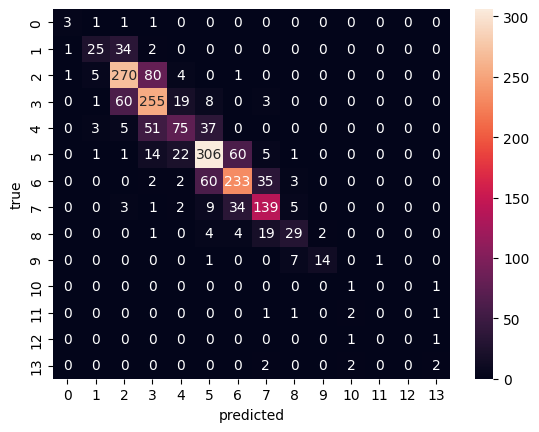

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


y_pred = rfecv_model.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

## RFECV + TFIDF Description

In [334]:
preprocess_tfidf = ColumnTransformer(
    [
        ("num", "passthrough", selected_num_cols),
        ("cat", TargetEncoder(), selected_cat_cols),
        ("text", TfidfVectorizer(max_features=5000, stop_words=pl_stopwords), text_col),
    ],
    remainder="drop",
)

model = Pipeline(
    [
        ("prep", preprocess_tfidf),
        ("clf", RandomForestClassifier(n_estimators=250, n_jobs=-1)),
    ]
)

model.fit(X_train, y_train)

/Users/tomekogiolda/Projects/agh/.conda/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['jeå', 'jä', 'li'] not in stop_words.
  warnings.warn(


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


accuracy: 0.712266532054518

report:
               precision    recall  f1-score   support

           2       1.00      0.33      0.50         6
           3       0.93      0.21      0.34        62
           4       0.69      0.84      0.76       361
           5       0.64      0.76      0.70       346
           6       0.78      0.40      0.53       171
           7       0.74      0.77      0.75       410
           8       0.70      0.73      0.72       335
           9       0.80      0.73      0.76       193
          10       0.78      0.73      0.75        59
          11       1.00      0.35      0.52        23
          12       0.50      1.00      0.67         2
          13       1.00      0.40      0.57         5
          14       1.00      0.50      0.67         2
          15       1.00      0.50      0.67         6

    accuracy                           0.71      1981
   macro avg       0.83      0.59      0.64      1981
weighted avg       0.73      0.71      0.7

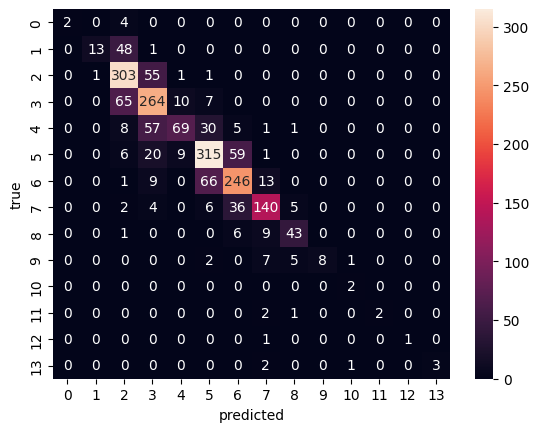

In [335]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


y_pred = model.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()